In [1]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Ashish Rout\AppData\Local\Temp\pip-install-xnegkj6a\tensorflow-gpu_3f7a1ea6756d4653a8af6e5d54f44d33\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu d

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

# Create the directory if it doesn't exist
os.makedirs(IMAGES_PATH, exist_ok=True)

for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    
    # Capture a frame from the camera
    ret, frame = cap.read()
    
    # Check if the frame was captured successfully
    if not ret:
        print("Error: Could not capture frame.")
        break
    
    # Generate a unique image name using UUID
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    
    # Save the captured frame as an image
    cv2.imwrite(imgname, frame)
    
    # Display the captured frame
    cv2.imshow('frame', frame)
    
    # Delay to allow time for displaying the frame (optional)
    time.sleep(0.5)
    
    # Check for the 'q' key press to exit capturing
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

In [7]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Ashish Rout\.labelmerc
qt.qpa.fonts: Unable to open default EUDC font: "EUDC.TTE"


In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [7]:
images.as_numpy_iterator().next()

b'data\\images\\da279e6c-552c-11ee-9cf8-5cbaefaad540.jpg'

In [8]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

array([[[46, 70, 54],
        [46, 70, 54],
        [48, 68, 57],
        ...,
        [64, 96, 81],
        [66, 97, 81],
        [66, 97, 81]],

       [[46, 66, 54],
        [46, 66, 54],
        [48, 65, 55],
        ...,
        [65, 96, 80],
        [67, 95, 80],
        [68, 96, 81]],

       [[51, 62, 54],
        [51, 62, 56],
        [53, 62, 57],
        ...,
        [65, 93, 78],
        [66, 93, 78],
        [67, 94, 77]],

       ...,

       [[45, 44, 40],
        [44, 43, 39],
        [44, 43, 38],
        ...,
        [51, 37, 28],
        [51, 37, 28],
        [51, 37, 28]],

       [[46, 45, 41],
        [45, 44, 40],
        [45, 44, 40],
        ...,
        [47, 34, 25],
        [48, 35, 26],
        [47, 34, 25]],

       [[44, 43, 39],
        [44, 43, 39],
        [44, 43, 39],
        ...,
        [45, 32, 23],
        [46, 33, 24],
        [45, 32, 23]]], dtype=uint8)

In [11]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [12]:
image_generator = images.batch(4).as_numpy_iterator()

In [13]:
plot_images = image_generator.next()

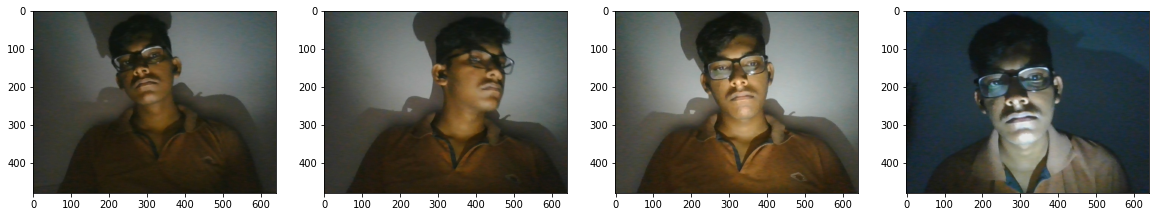

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [20]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)    

In [21]:
import albumentations as alb

In [22]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [23]:
img = cv2.imread(os.path.join('data','train', 'images','199caf37-552d-11ee-b33c-5cbaefaad540.jpg'))

In [24]:
with open(os.path.join('data', 'train', 'labels', '199caf37-552d-11ee-b33c-5cbaefaad540.json'), 'r') as f:
    label = json.load(f)

In [25]:
label['shapes'][0]['points']

[[279.8484848484849, 26.363636363636367],
 [462.42424242424244, 298.3333333333333]]

In [26]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [27]:
coords

[279.8484848484849, 26.363636363636367, 462.42424242424244, 298.3333333333333]

In [28]:
coords = list(np.divide(coords, [640,480,640,480]))

In [29]:
coords

[0.4372632575757576,
 0.05492424242424243,
 0.7225378787878788,
 0.6215277777777778]

In [30]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [31]:
augmented['bboxes'][0][2:]

(0.5336700336700336, 0.9925252525252525)

In [32]:
augmented['bboxes']

[(0.12794612794612792,
  0.38814814814814824,
  0.5336700336700336,
  0.9925252525252525)]

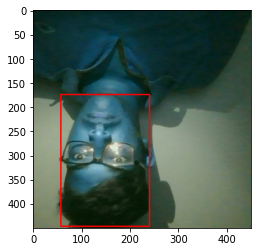

In [33]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [34]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [35]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [36]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [37]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [38]:
train_images.as_numpy_iterator().next()

array([[[0.16470589, 0.11574755, 0.04944853],
        [0.16752452, 0.12432598, 0.06127451],
        [0.17009804, 0.11519608, 0.06421569],
        ...,
        [0.10098039, 0.08088236, 0.03921569],
        [0.09283088, 0.07371324, 0.04871324],
        [0.08737745, 0.07205883, 0.05790441]],

       [[0.15275735, 0.12138481, 0.046875  ],
        [0.14601716, 0.11758579, 0.04834559],
        [0.16127451, 0.10637255, 0.05539216],
        ...,
        [0.10588235, 0.07058824, 0.03627451],
        [0.10245098, 0.07401961, 0.05      ],
        [0.09080882, 0.07610294, 0.05306372]],

       [[0.1398897 , 0.11243872, 0.03792892],
        [0.14515932, 0.11672794, 0.04319853],
        [0.15251225, 0.10545343, 0.04270833],
        ...,
        [0.1028799 , 0.07457108, 0.04362745],
        [0.10330883, 0.08186275, 0.05833333],
        [0.10153186, 0.0872549 , 0.0721201 ]],

       ...,

       [[0.38216913, 0.43566176, 0.41783088],
        [0.38088235, 0.43823528, 0.41911766],
        [0.38039216, 0

In [39]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [40]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1521, 0.3662, 0.6167, 0.972 ], dtype=float16))

In [44]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [45]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [46]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [47]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [48]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1475  , 0.012054, 0.602   , 0.5625  ],
        [0.      , 0.      , 0.61    , 0.4607  ],
        [0.5273  , 0.442   , 0.9805  , 1.      ],
        [0.      , 0.2461  , 0.4944  , 0.96    ],
        [0.174   , 0.095   , 0.649   , 0.706   ],
        [0.      , 0.2037  , 0.4146  , 0.8467  ],
        [0.1943  , 0.5015  , 0.5933  , 1.      ],
        [0.252   , 0.4885  , 0.809   , 1.      ]], dtype=float16))

In [49]:
data_samples = train.as_numpy_iterator()

In [50]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


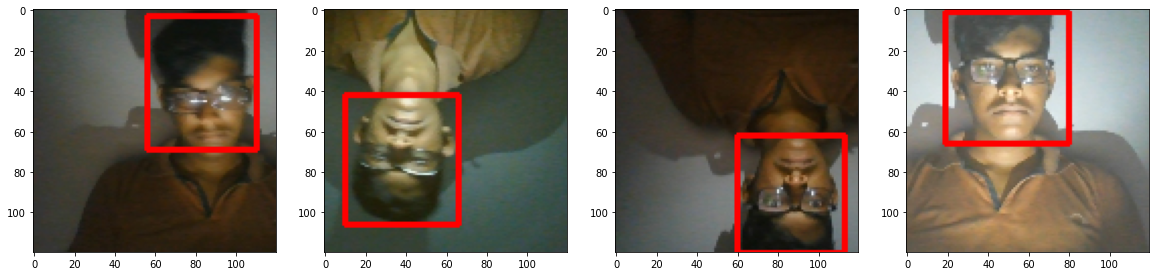

In [51]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [53]:
vgg = VGG16(include_top=False)

In [54]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [55]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [56]:
facetracker = build_model()

In [57]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [58]:
X, y = train.as_numpy_iterator().next()

In [59]:
X

array([[[[0.32469362, 0.3897059 , 0.422549  ],
         [0.33939952, 0.38805148, 0.4480392 ],
         [0.35441175, 0.38805148, 0.44509804],
         ...,
         [0.37726715, 0.4321691 , 0.44099265],
         [0.38045344, 0.42579657, 0.43075982],
         [0.38878676, 0.43094364, 0.42849264]],

        [[0.33811274, 0.3887255 , 0.41911766],
         [0.3456495 , 0.38866422, 0.41127452],
         [0.35735294, 0.3920956 , 0.4117647 ],
         ...,
         [0.38278186, 0.4273897 , 0.44172794],
         [0.37542892, 0.42303923, 0.42395833],
         [0.37273285, 0.41862744, 0.42322305]],

        [[0.34509805, 0.39313725, 0.4137255 ],
         [0.35729167, 0.39650735, 0.40392157],
         [0.3647059 , 0.39607844, 0.40392157],
         ...,
         [0.3598652 , 0.4264093 , 0.45373774],
         [0.3641544 , 0.42297795, 0.4356005 ],
         [0.3565564 , 0.41930148, 0.41685048]],

        ...,

        [[0.35588235, 0.31194854, 0.27904412],
         [0.37751225, 0.32947305, 0.27506128]

In [60]:
y

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2438 , 0.1556 , 0.712  , 0.7466 ],
        [0.0641 , 0.442  , 0.517  , 1.     ],
        [0.2439 , 0.2366 , 0.806  , 0.927  ],
        [0.     , 0.0938 , 0.5127 , 0.6646 ],
        [0.56   , 0.07214, 1.     , 0.6445 ],
        [0.2286 , 0.04465, 0.67   , 0.6523 ],
        [0.2888 , 0.4958 , 0.7383 , 1.     ],
        [0.4255 , 0.43   , 0.875  , 0.9805 ]], dtype=float16))

In [61]:
X.shape

(8, 120, 120, 3)

In [62]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 4s 4s/step


In [63]:
classes, coords

(array([[0.2502216 ],
        [0.2628401 ],
        [0.22225945],
        [0.2596592 ],
        [0.24572067],
        [0.2739624 ],
        [0.24778016],
        [0.25316754]], dtype=float32),
 array([[0.34611386, 0.49508858, 0.5143921 , 0.3742424 ],
        [0.47684503, 0.5959405 , 0.43211055, 0.5150408 ],
        [0.45019072, 0.5791824 , 0.4659265 , 0.5243936 ],
        [0.54412   , 0.56699526, 0.47336674, 0.4794791 ],
        [0.40945745, 0.5492687 , 0.5007391 , 0.45644596],
        [0.36229092, 0.57146084, 0.5034032 , 0.4473413 ],
        [0.48077214, 0.5514208 , 0.45843726, 0.5280619 ],
        [0.4748454 , 0.5579899 , 0.515828  , 0.4699756 ]], dtype=float32))

In [64]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [65]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [66]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [67]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [68]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.75041>

In [69]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3801439>

In [70]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.75041>

In [71]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [72]:
model = FaceTracker(facetracker)

In [73]:
model.compile(opt, classloss, regressloss)

In [74]:
logdir='logs'

In [75]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 1111s 2s/step - total_loss: 0.0943 - class_loss: 0.0075 - regress_loss: 0.0906 - val_total_loss: 0.0347 - val_class_loss: 1.8686e-05 - val_regress_loss: 0.0347
Epoch 2/10
473/473 [==============================] - 1308s 3s/step - total_loss: 0.0195 - class_loss: 4.3798e-06 - regress_loss: 0.0195 - val_total_loss: 0.0063 - val_class_loss: 1.0580e-06 - val_regress_loss: 0.0063
Epoch 3/10
473/473 [==============================] - 1295s 3s/step - total_loss: 0.0115 - class_loss: 1.0808e-06 - regress_loss: 0.0115 - val_total_loss: 0.0097 - val_class_loss: 1.2517e-06 - val_regress_loss: 0.0097
Epoch 4/10
473/473 [==============================] - 1056s 2s/step - total_loss: 0.0072 - class_loss: 6.1578e-07 - regress_loss: 0.0072 - val_total_loss: 0.0122 - val_class_loss: 1.3858e-06 - val_regress_loss: 0.0122
Epoch 5/10
473/473 [==============================] - 1071s 2s/step - total_loss: 0.0058 - class_loss: 4.1840e-07 - regress_loss: 0.

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()